In [1]:
import pandas as pd
import yfinance as yf
from ta.utils import dropna
from ta.trend import MACD, EMAIndicator, SMAIndicator
import matplotlib.pyplot as plt

In [7]:
# Load data
data = yf.download("EURUSD=x", period="5d", interval="1h")
data.index = pd.to_datetime(data.index)
data = data.drop(columns=['Adj Close', 'Volume'])
data = dropna(data)

[*********************100%%**********************]  1 of 1 completed


In [47]:
# Define parameters
fast_length = 12
slow_length = 26
signal_length = 9
veryslow_length = 200

# Calculate indicators
macd = MACD(close=data["Close"], window_slow=26, window_fast=12, window_sign=9)
fast_ma = SMAIndicator(data['Close'], window=12).sma_indicator()
slow_ma = SMAIndicator(data['Close'], window=26).sma_indicator()
veryslow_ma = SMAIndicator(data['Close'], 50).sma_indicator()


In [48]:
def strategy_logic(data, macd, fast_ma, slow_ma, veryslow_ma):
    buy_signal = False
    sell_signal = False
    prev_signal = None

    for i in range(len(data)):
        macd_val = macd.macd()[i]
        macd_diff = macd.macd_diff()[i]
        fast_ma_val = fast_ma[i]
        slow_ma_val = slow_ma[i]
        close_val = data['Close'][i]
        veryslow_ma_val = veryslow_ma[i]

        if (macd_val > 0) & (macd_diff > 0) & (fast_ma_val > slow_ma_val) & (close_val > veryslow_ma_val):
            if prev_signal != 'buy':
                buy_signal = True
                prev_signal = 'buy'
            else:
                buy_signal = False

        elif (macd_val < 0) & (macd_diff < 0) & (fast_ma_val < slow_ma_val) & (close_val < veryslow_ma_val):
            if prev_signal != 'sell':
                sell_signal = True
                prev_signal = 'sell'
            else:
                sell_signal = False

        else:
            buy_signal = False
            sell_signal = False

        yield buy_signal, sell_signal


In [49]:
buy_signals = []
sell_signals = []

for buy, sell in strategy_logic(data, macd, fast_ma, slow_ma, veryslow_ma):
    buy_signals.append(buy)
    sell_signals.append(sell)


C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_9824\3431868097.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  macd_val = macd.macd()[i]
C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_9824\3431868097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  macd_diff = macd.macd_diff()[i]
C:\Users\Peace Pearl\AppData\Local\Temp\ipykernel_9824\3431868097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fast_ma_val = fast_ma[i]

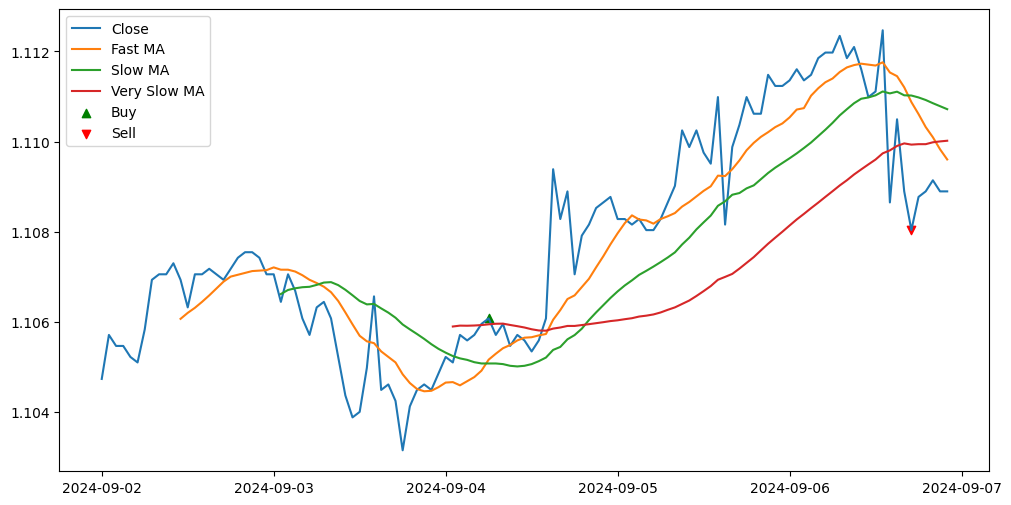

In [50]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close')
plt.plot(fast_ma, label='Fast MA')
plt.plot(slow_ma, label='Slow MA')
plt.plot(veryslow_ma, label='Very Slow MA')
plt.scatter(data.index[buy_signals], data['Close'][buy_signals], label='Buy', marker='^', color='g')
plt.scatter(data.index[sell_signals], data['Close'][sell_signals], label='Sell', marker='v', color='r')
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

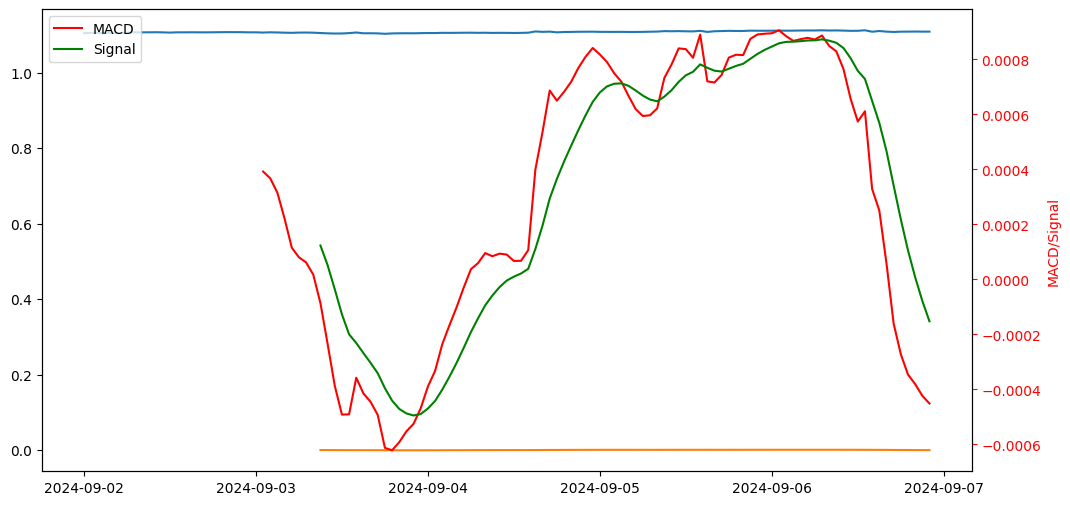

In [51]:
# Plot data and signals
plt.figure(figsize=(12,6))
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(data['Close'], label='Close')
ax1.plot(macd.macd_signal(), label='Signal')

ax2 = ax1.twinx()
ax2.plot(macd.macd(), label='MACD', color='r')
ax2.plot(macd.macd_signal(), label='Signal', color='g')
ax2.set_ylabel('MACD/Signal', color='r')
ax2.tick_params('y', colors='r')

plt.legend(loc='upper left')
plt.show()

